# Train ML

> A collection of machine learning tools

## Setup

In [1]:
#| default_exp train

In [ ]:
#| hide
import sys
sys.path.append("/notebooks/katlas")
from nbdev.showdoc import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
# katlas
from katlas.core import Data
from katlas.feature import *

# essentials
from fastbook import *
from joblib import dump, load
import math, xgboost as xgb, matplotlib.pyplot as plt
from pathlib import Path

# scipy
from scipy.stats import spearmanr, pearsonr
from scipy.stats import spearmanr,pearsonr

# sklearn
from sklearn.model_selection import *
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import *
from sklearn.svm import *
from sklearn.ensemble import *
from sklearn import set_config
set_config(transform_output="pandas")

## Utils

### Splitter

In [ ]:
#| export
def get_splits(df: pd.DataFrame, # df contains info for split
               stratified: str=None, # colname to make stratified kfold; sampling from different groups
               group: str=None, # colname to make group kfold; test and train are from different groups
               nfold: int=5,
               seed: int=123):
    
    "Split samples in a dataframe based on Stratified, Group, or StratifiedGroup Kfold method"
    def _log(colname):
        print(kf)
        split=splits[0]
        print(f'# kinase {colname} in train set: {df.loc[split[0]][colname].unique().shape[0]}')
        print(f'# kinase {colname} in test set: {df.loc[split[1]][colname].unique().shape[0]}')
        
    splits = []
    if stratified is not None and group is None:
        kf = StratifiedKFold(nfold, shuffle=True, random_state=seed)
        for split in kf.split(df.index, df[stratified]):
            splits.append(split)
            
        _log(stratified)
        
    elif group is not None and stratified is None:
        kf = GroupKFold(nfold)
        for split in kf.split(df.index, groups=df[group]):
            splits.append(split)
            
        _log(group)
        
    elif stratified is not None and group is not None:
        kf = StratifiedGroupKFold(nfold, shuffle=True, random_state=seed)
        for split in kf.split(df.index, groups=df[group], y=df[stratified]):
            splits.append(split)
            
        _log(stratified)

    else:
        raise ValueError("Either 'stratified' or 'group' argument must be provided.")
        
        
    print('---------------------------')
    print(f'# kinase in train set: {df.loc[split[0]].kinase.unique().shape[0]}')
    
    print('---------------------------')
    print(f'# kinase in test set: {df.loc[split[1]].kinase.unique().shape[0]}')
    print('---------------------------')
    print(f'test set: {df.loc[split[1]].kinase.unique()}')
    
    return splits

In [ ]:
# read training data
df = pd.read_parquet('train_data/combine_t5_kd.parquet').reset_index()

# read data contains info for split
info_df = Data.get_kinase_info().query('pseudo!="1"') # get non-pseudo kinase

In [ ]:
# merge info with training data
info = df[['kinase']].merge(info_df)
info.head()

,kinase,ID_coral,uniprot,ID_HGNC,group,family,subfamily_coral,subfamily,in_ST_paper,in_Tyr_paper,in_cddm,pseudo,pspa_category_small,pspa_category_big,cddm_big,cddm_small,length,human_uniprot_sequence,kinasecom_domain,nucleus,cytosol,cytoskeleton,plasma membrane,mitochondrion,Golgi apparatus,endoplasmic reticulum,vesicle,centrosome,aggresome,main_location
0,SRC,SRC,P12931,SRC,TK,Src,None,Src,0,1,1,0,SRC,SRC,1.0,2.0,536,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADGHRGPSAAFAPAAAEPKLFGGFNSSDTVTSPQRAGPLAGGVTTFVALYDYESRTETDLSFKKGERLQIVNNTEGDWWLAHSLSTGQTGYIPSNYVAPSDSIQAEEWYFGKITRRESERLLLNAENPRGTFLVRESETTKGAYCLSVSDFDNAKGLNVKHYKIRKLDSGGFYITSRTQFNSLQQLVAYYSKHADGLCHRLTTVCPTSKPQTQGLAKDAWEIPRESLRLEVKLGQGCFGEVWMGTWNGTTRVAIKTLKPGTMSPEAFLQEAQVMKKLRHEKLVQLYAVVSEEPIYIVTEYMSKGSLLDFLKGETGKYLRLPQLVDMAAQIASGMAYVERMNYVHRDLRAANILVGENLVCKVADFGLARLIEDNEYTARQGAKFPIKWTAPEAALYGRFTIKSDVWSFGILLTELTTKGRVPYPGMVNREVLDQVERGYRMPCPPECPESLHDLMCQCWRKEPEERPTFEYLQAFLEDYFTSTEPQYQPGENL,LRLEVKLGQGCFGEVWMGTWNGTTRVAIKTLKPGTMSPEAFLQEAQVMKKLRHEKLVQLYAVVSEEPIYIVTEYMSKGSLLDFLKGETGKYLRLPQLVDMAAQIASGMAYVERMNYVHRDLRAANILVGENLVCKVADFGLARLIEDNEYTARQGAKFPIKWTAPEAALYGRFTIKSDVWSFGILLTELTTKGRVPYPGMVNREVLDQVERGYRMPCPPECPESLHDLMCQCWRKEPEERPTFEYLQAF,NaN,2.0,NaN,6.0,NaN,2.0,NaN,NaN,NaN,NaN,plasma membrane
1,EPHA3,EphA3,P29320,EPHA3,TK,Eph,None,Eph,0,1,1,0,Ephrin receptors,Ephrin receptors,1.0,2.0,983,MDCQLSILLLLSCSVLDSFGELIPQPSNEVNLLDSKTIQGELGWISYPSHGWEEISGVDEHYTPIRTYQVCNVMDHSQNNWLRTNWVPRNSAQKIYVELKFTLRDCNSIPLVLGTCKETFNLYYMESDDDHGVKFREHQFTKIDTIAADESFTQMDLGDRILKLNTEIREVGPVNKKGFYLAFQDVGACVALVSVRVYFKKCPFTVKNLAMFPDTVPMDSQSLVEVRGSCVNNSKEEDPPRMYCSTEGEWLVPIGKCSCNAGYEERGFMCQACRPGFYKALDGNMKCAKCPPHSSTQEDGSMNCRCENNYFRADKDPPSMACTRPPSSPRNVISNINETSVILDWSWPLDTGGRKDVTFNIICKKCGWNIKQCEPCSPNVRFLPRQFGLTNTTVTVTDLLAHTNYTFEIDAVNGVSELSSPPRQFAAVSITTNQAAPSPVLTIKKDRTSRNSISLSWQEPEHPNGIILDYEVKYYEKQEQETSYTILRARGTNVTISSLKPDTIYVFQIRARTAAGYGTNSRKFEFETSPDSFSISGESSQVVMIAISAAVAIILLTVVIYVLIGRFCGYKSKHGADEKRLHFGNGHLKLPGLRTY...,ISIDKVVGAGEFGEVCSGRLKLPSKKEISVAIKTLKVGYTEKQRRDFLGEASIMGQFDHPNIIRLEGVVTKSKPVMIVTEYMENGSLDSFLRKHDAQFTVIQLVGMLRGIASGMKYLSDMGYVHRDLAARNILINSNLVCKVSDFGLSRVLEDDPEAAYTTRGGKIPIRWTSPEAIAYRKFTSASDVWSYGIVLWEVMSYGERPYWEMSNQDVIKAVDEGYRLPPPMDCPAALYQLMLDCWQKDRNNRPKFEQIVSI,NaN,1.0,NaN,6.0,NaN,3.0,NaN,NaN,NaN,NaN,plasma membrane
2,FES,FES,P07332,FES,TK,Fer,None,Fer,0,1,1,0,TAM receptors,TAM receptors,1.0,2.0,822,MGFSSELCSPQGHGVLQQMQEAELRLLEGMRKWMAQRVKSDREYAGLLHHMSLQDSGGQSRAISPDSPISQSWAEITSQTEGLSRLLRQHAEDLNSGPLSKLSLLIRERQQLRKTYSEQWQQLQQELTKTHSQDIEKLKSQYRALARDSAQAKRKYQEASKDKDRDKAKDKYVRSLWKLFAHHNRYVLGVRAAQLHHQHHHQLLLPGLLRSLQDLHEEMACILKEILQEYLEISSLVQDEVVAIHREMAAAAARIQPEAEYQGFLRQYGSAPDVPPCVTFDESLLEEGEPLEPGELQLNELTVESVQHTLTSVTDELAVATEMVFRRQEMVTQLQQELRNEEENTHPRERVQLLGKRQVLQEALQGLQVALCSQAKLQAQQELLQTKLEHLGPGEPPPVLLLQDDRHSTSSSEQEREGGRTPTLEILKSHISGIFRPKFSLPPPLQLIPEVQKPLHEQLWYHGAIPRAEVAELLVHSGDFLVRESQGKQEYVLSVLWDGLPRHFIIQSLDNLYRLEGEGFPSIPLLIDHLLSTQQPLTKKSGVVLHRAVPKDKWVLNHEDLVLGEQIGRGNFGEVFSGRLRADNTLVAVKSCRETL...,LVLGEQIGRGNFGEVFSGRLRADNTLVAVKSCRETLPPDLKAKFLQEARILKQYSHPNIVRLIGVCTQKQPIYIVMELVQGGDFLTFLRTEGARLRVKTLLQMVGDAAAGMEYLESKCCIHRDLAARNCLVTEKNVLKISDFGMSREEADGVYAASGGLRQVPVKWTAPEALNYGRYSSESDVWSFGILLWETFSLGASPYPNLSNQQTREFVEKGGRLPCPELCPDAVFRLMEQCWAYEPGQRPSFSTIYQELQS,NaN,6.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,cytosol
3,NTRK3,TRKC,Q16288,NTRK3,TK,Trk,None,Trk,0,1,1,0,Insulin and neurotrophin receptors,Insulin and neurotrophin receptors,1.0,3.0,839,MDVSLCPAKCSFWRIFLLGSVWLDYVGSVLACPANCVCSKTEINCRRPDDGNLFPLLEGQDSGNSNGNASINITDISRNITSIHIENWRSLHTLNAVDMELYTGLQKLTIKNSGLRSIQPRAFAKNPHLRYINLSSNRLTTLSWQLFQTLSLRELQLEQNFFNCSCDIRWMQLWQEQGEAKLNSQNLYCINADGSQLPLFRMNISQCDLPEISVSHVNLTVREGDNAVITCNGSGSPLPDVDWIVTGLQSINTHQTNLNWTNVHAINLTLVNVTSEDNGFTLTCIAENVVGMSNASVALTVYYPPRVVSLEEPELRLEHCIEFVVRGNPPPTLHWLHNGQPLRESKIIHVEYYQEGEISEGCLLFNKPTHYNNGNYTLIAKNPLGTANQTINGHFLKEPFPESTDNFILFDEVSPTPPITVTHKPEEDTFGVSIAVGLAAFACVLLVVLFVMINKYGRRSKFGMKGPVAVISGEEDSASPLHHINHGITTPSSLDAGPDTVVIGMTRIPVIENPQYFRQGHNCHKPDTYVQHIKRRDIVLKRELGEGAFGKVFLAECYNLSPTKDKMLVAVKALKDPTLAARKDFQREAELLTNLQ...,IV

In [ ]:
# stratify samples based on group
splits = get_splits(info,stratified='group')
len(splits)
split0 = splits[0]

StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
# kinase group in train set: 9
# kinase group in test set: 9
---------------------------
# kinase in train set: 312
---------------------------
# kinase in test set: 78
---------------------------
test set: ['EPHA3' 'FES' 'FLT3' 'FYN' 'EPHB1' 'EPHB3' 'FER' 'EPHB4' 'FLT4' 'FGFR1' 'EPHA5' 'TEK' 'DDR2' 'ZAP70' 'LIMK1' 'ULK3' 'JAK1' 'WEE1' 'TESK1' 'MAP2K3' 'AMPKA2' 'ATM' 'CAMK1D' 'CAMK2D' 'CAMK4' 'CAMKK1'
 'CK1D' 'CK1E' 'DYRK2' 'DYRK4' 'HGK' 'IKKE' 'JNK2' 'JNK3' 'KHS1' 'MAPKAPK5' 'MEK2' 'MSK2' 'NDR1' 'NEK6' 'NEK9' 'NIM1' 'NLK' 'OSR1' 'P38A' 'P38B' 'P90RSK' 'PAK1' 'PERK' 'PKCH' 'PKCI' 'PKN1' 'ROCK2'
 'RSK2' 'SIK' 'STLK3' 'TAK1' 'TSSK1' 'ALPHAK3' 'BMPR2' 'CDK10' 'CDK13' 'CDK14' 'CDKL5' 'GCN2' 'GRK4' 'IRE1' 'KHS2' 'MASTL' 'MLK4' 'MNK1' 'MRCKA' 'PRPK' 'QSK' 'SMMLCK' 'SSTK' 'ULK2' 'VRK1']


In [ ]:
feat_col = df.columns[df.columns.str.startswith('T5_')]

target_col = df.columns[~df.columns.isin(feat_col)][1:]

In [ ]:
#| export
def split_data(df: pd.DataFrame, # dataframe of values
               feat_col: list, # feature columns
               target_col: list, # target columns
               split: tuple # one of the split in splits
               ):
    "Given split tuple, split dataframe into X_train, y_train, X_test, y_test"
    
    X_train = df.loc[split[0]][feat_col]
    y_train = df.loc[split[0]][target_col]
    
    X_test = df.loc[split[1]][feat_col]
    y_test = df.loc[split[1]][target_col]
    
    return X_train, y_train, X_test, y_test

In [ ]:
X_train, y_train, X_test, y_test = split_data(df,feat_col, target_col, split0)

In [ ]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((312, 1024), (312, 210), (78, 1024), (78, 210))

### Scoring

In [ ]:
#| export
def score_each(target: pd.DataFrame, # target dataframe
              pred: pd.DataFrame, # predicted dataframe
              absolute = True, # if absolute, take average with absolute values for pearson/spearman
              verbose=True, # whether or not display the error value
              
             ):
    
    "Calculate the overall MSE and average Pearson (per row) between two dataframes."
    
    # Calculate overall MSE
    mse = mean_squared_error(target, pred)
    
    # Calculate RMSE
    # rmse = math.sqrt(mse)

    # Calculate the Spearman correlation coefficient
    # spearman, _ = spearmanr(target.values.ravel(), pred.values.ravel())

    # Calculate the Pearson correlation coefficient
    # pearson, _ = pearsonr(target.values.ravel(), pred.values.ravel())
    
    # Calculate Spearman and Pearson per row 
    # spearman_all = target.corrwith(pred,axis=1,method='spearman')
    pearson_all = target.corrwith(pred,axis=1,method='pearson')
    
    # Calculate mean
    # spearman_mean = spearman_all.abs().mean()
    pearson_mean = pearson_all.abs().mean()
    
    metrics_df = pd.DataFrame({'Pearson':pearson_all})
    
    if verbose:
        print(f'overall MSE: {mse:.4f}')
        # print(f"Average Spearman:  {spearman_mean:.4f}")
        print(f"Average Pearson: {pearson_mean:.4f} ")
    
    return mse,pearson_mean, metrics_df

In [ ]:
mse,pearson_avg,pearson_all = score_each(y_test, y_test)

overall MSE: 0.0000
Average Pearson: 1.0000 


In [ ]:
pearson_all.head()

,Pearson
3,1.0
8,1.0
10,1.0
19,1.0
24,1.0


## Machine Learning
> for regression task

### Trainer

In [ ]:
#| export
def train_ml(df, # dataframe of values
             feat_col, # feature columns
             target_col, # target columns
             split, # one split in splits
             model,  # a sklearn models
             save = None, # file (.joblib) to save, e.g. 'model.joblib'
             params={}, # parameters for model.fit from sklearn
            ):
    
    "Fit and predict using sklearn model format, return target and pred of valid dataset."
    
    # split data
    X_train, y_train, X_test, y_test = split_data(df, feat_col, target_col, split)
    
    # Fit the model
    model.fit(X_train, y_train, **params) # better convert y_train to numpy array and flatten
    print(model)
    
    if save is not None:
        # Save the model to a file
        # joblib.dump(model, save)
        dump(model, save)
        
    # Predict train
    y_train_pred = model.predict(X_train) # X_test is dataframe, y_pred is numpy array
    
    # Predict test
    y_pred = model.predict(X_test) # X_test is dataframe, y_pred is numpy array

    # Make dataframe
    y_pred = pd.DataFrame(y_pred,index=y_test.index, columns = y_test.columns)
    
    return y_test, y_pred

In [ ]:
model = LinearRegression()
# target,pred = train_ml(df, feat_col, target_col, split0, model,'raw/model.joblib')
target,pred = train_ml(df, feat_col, target_col, split0, model)

pred.head()

LinearRegression()


,-5P,-5G,-5A,-5C,-5S,-5T,-5V,-5I,-5L,-5M,-5F,-5Y,-5W,-5H,-5K,-5R,-5Q,-5N,-5D,-5E,-5s,-5t,-5y,-4P,-4G,-4A,-4C,-4S,-4T,-4V,-4I,-4L,-4M,-4F,-4Y,-4W,-4H,-4K,-4R,-4Q,-4N,-4D,-4E,-4s,-4t,-4y,-3P,-3G,-3A,-3C,-3S,-3T,-3V,-3I,-3L,-3M,-3F,-3Y,-3W,-3H,-3K,-3R,-3Q,-3N,-3D,-3E,-3s,-3t,-3y,-2P,-2G,-2A,-2C,-2S,-2T,-2V,-2I,-2L,-2M,-2F,-2Y,-2W,-2H,-2K,-2R,-2Q,-2N,-2D,-2E,-2s,-2t,-2y,-1P,-1G,-1A,-1C,-1S,-1T,-1V,-1I,-1L,-1M,-1F,-1Y,-1W,-1H,-1K,-1R,-1Q,-1N,-1D,-1E,-1s,-1t,-1y,1P,1G,1A,1C,1S,1T,1V,1I,1L,1M,1F,1Y,1W,1H,1K,1R,1Q,1N,1D,1E,1s,1t,1y,2P,2G,2A,2C,2S,2T,2V,2I,2L,2M,2F,2Y,2W,2H,2K,2R,2Q,2N,2D,2E,2s,2t,2y,3P,3G,3A,3C,3S,3T,3V,3I,3L,3M,3F,3Y,3W,3H,3K,3R,3Q,3N,3D,3E,3s,3t,3y,4P,4G,4A,4C,4S,4T,4V,4I,4L,4M,4F,4Y,4W,4H,4K,4R,4Q,4N,4D,4E,4s,4t,4y,0s,0t,0y
3,-0.364707,0.870501,0.991939,-1.122006,-0.290667,-0.833366,-0.307455,-0.324753,0.471472,-1.073353,-0.812464,-1.434765,-1.350083,-1.271137,1.800298,0.974743,0.116519,0.744288,1.985861,2.331726,-0.413103,-0.471491,-0.217838,-0.247941,1.292480,0.244995,-0.891201,-0.536663,-0.804740,0.428205,-0.086208,1.264944,-1.158690,-0.408965,-1.493815,-1.168097,-0.991530,0.758574,1.455711,-0.190510,-0.031299,1.957698,1.849005,0.213270,-0.796449,-0.658697,-0.061393,0.335216,1.229836,-1.199328,-0.880915,-1.180625,0.474172,-0.231705,1.040083,-1.320546,-0.500661,-1.444532,-1.220846,-0.539033,1.032884,-0.167849,0.402668,0.142277,1.606714,2.048386,0.609752,-0.409203,0.234526,-0.374300,0.595023,0.711315,-0.947360,-0.875062,-1.197055,-0.373876,-0.127561,0.149932,-1.376348,-0.821782,-1.700367,-1.061799,-1.077019,0.975288,1.281217,-0.216851,0.232975,2.334243,2.257738,0.741782,-0.343032,1.212808,-0.721960,0.433344,0.901258,-0.993851,-0.923428,-1.240503,0.247750,0.237647,1.308000,-1.448115,-0.210287,-1.602614,-1.224206,-0.771882,0.307644,-0.361465,0.193351,0.875552,2.765148,1.398163,0.031033,-0.140698,0.940186,-2.415734,1.794049,1.064599,-0.665642,-1.398878,-1.206198,2.164858,1.292426,0.896056,-1.059209,-0.072301,-1.666331,-1.448606,-0.671760,0.142948,-0.818149,0.341993,-0.693898,1.257253,2.420482,0.679768,-0.467398,0.529559,-0.201342,-0.046525,1.260589,-0.405474,-1.213921,-1.201158,0.671173,-0.063247,1.122971,-0.608822,0.330831,-1.727682,-1.080166,-0.310707,0.212629,0.484047,0.237114,0.537202,1.294311,1.613692,0.065542,-0.407601,-0.563342,-0.303835,0.010657,0.690046,-0.584377,-1.130737,-1.086326,1.374406,1.106638,3.509956,-0.697685,-0.028091,-1.351033,-1.100004,-0.896113,0.106874,0.872651,-0.538471,-0.628911,0.592987,0.662206,-0.040950,-0.359280,-0.180524,0.471878,0.807249,0.916216,-1.005140,-0.735050,-0.841288,0.429646,-0.462429,0.806671,-0.801938,-0.263505,-1.245028,-0.900780,-0.736740,1.254654,0.862569,-0.011711,0.108451,0.909329,1.577520,-0.199625,-0.255603,-0.685361,-0.775611,-0.584843,1.360464
8,0.094880,0.943445,0.534657,-1.164017,-0.481484,-0.721019,0.194848,-0.108135,0.560754,-1.158064,-0.261648,-1.330354,-1.198559,-0.973158,2.034347,0.765188,0.708631,0.480957,1.458316,1.806352,-0.680310,-0.982514,-0.522106,-0.020348,1.502482,0.386448,-0.937715,-0.552971,-0.670327,0.616476,-0.048377,1.117217,-0.955937,-0.441204,-1.386428,-0.925580,-0.690133,1.070817,0.465711,-0.054884,-0.092478,1.455645,1.364479,0.227138,-0.579721,-0.849840,-0.082119,0.733043,1.242609,-0.987145,-0.754413,-0.807264,0.640982,0.088161,1.170935,-0.964818,-0.627630,-1.389539,-1.428106,-0.675190,0.566198,0.060587,0.067555,0.200230,1.412501,1.655164,0.429707,-0.241574,-0.310633,0.579110,0.684921,0.773356,-1.068141,-0.861840,-1.025491,0.332373,0.291397,0.352253,-1.216874,-0.980455,-1.923013,-1.348364,-1.029345,1.264398,0.704389,-0.053480,0.238599,1.530757,2.148098,0.480477,-0.206869,0.333178,-1.037978,-0.191798,0.646448,-1.011805,-1.106884,-1.010696,0.660367,0.684997,2.409452,-1.373009,-0.193996,-1.702466,-1.257548,-0.950701,0.281967,-0.061367,-0.516400,0.883593,2.911111,1.839703,-0.180538,0.028359,0.249610,-0.422202,1.516919,1.048154,-0.699110,-1.233507,-1.222338,1.272061,0.667691,0.365978,-1.238067,-0.441393,-1.600342,-1.126943,-0.805258,0.035632,-0.7

### Cross-Validation

In [ ]:
#| export
def train_ml_cv( df, # dataframe of values
                 feat_col, # feature columns
                 target_col,  # target columns
                 splits, # splits
                 model, # sklearn model
                 save = None, # model name to be saved, e.g., 'LR'
                 params = {}, # act as kwargs, for model.fit
                ):
    
    "Cross-validation through the given splits"
    
    OOF = []
    metrics = []
    
    for fold, split in enumerate(splits):
        print(f'------ fold: {fold} --------')
        
        if save is not None: 
            save = f'models/{save}_{fold}.joblib'
            
        target, pred = train_ml(df, feat_col, target_col, split, model,save,params=params)

        mse, pearson_avg, _ = score_each(target,pred)
        
        # Store metrics in a dictionary for the current fold
        fold_metrics = {
            'fold': fold,
            'mse': mse,
            'pearson_avg': pearson_avg
        }
        
        metrics.append(fold_metrics)

        OOF.append(pred)
        
    # Concatenate OOF from each fold to a new dataframe
    oof = pd.concat(OOF).sort_index()
    
    # Get metrics into a dataframe
    metrics = pd.DataFrame(metrics)
    
    return oof, metrics

In [ ]:
oof,metrics = train_ml_cv(df,feat_col,target_col,splits,model)

------ fold: 0 --------
LinearRegression()
overall MSE: 0.8763
Average Pearson: 0.7168 
------ fold: 1 --------
LinearRegression()
overall MSE: 0.6405
Average Pearson: 0.7313 
------ fold: 2 --------
LinearRegression()
overall MSE: 0.7465
Average Pearson: 0.7429 
------ fold: 3 --------
LinearRegression()
overall MSE: 0.6453
Average Pearson: 0.7328 
------ fold: 4 --------
LinearRegression()
overall MSE: 0.7906
Average Pearson: 0.7263 


In [ ]:
metrics

,fold,mse,pearson_avg
0,0,0.876272,0.716824
1,1,0.640510,0.731334
2,2,0.746505,0.742892
3,3,0.645263,0.732806
4,4,0.790577,0.726296


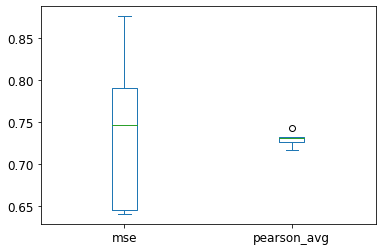

In [ ]:
# plot spearman and pearson scores
metrics.iloc[:,1:].plot.box();

In [ ]:
# Overall score for oof
_,_,corr_df= score_each(oof,df[target_col])

overall MSE: 0.7398
Average Pearson: 0.7300 


In [ ]:
corr_df.sort_values('Pearson').head() # lowest Pearson

,Pearson
81,-0.243886
156,-0.238927
313,-0.197956
381,-0.151646
205,-0.081901


### Predictor

In [ ]:
#| export
def predict_ml(df, # Dataframe that contains features
               feat_col, # feature columns
               target_col=None,
               model_pth = 'model.joblib'
              ):
    
    "Make predictions based on trained model."
    
    test = df[feat_col]
    
    model = load(model_pth)
    
    pred = model.predict(test)
    
    pred_df = pd.DataFrame(pred,index=df.index,columns=target_col)
    
    return pred_df

In [ ]:
pred2 = predict_ml(X_test,feat_col, target_col, model_pth = 'raw/model.joblib')
pred2.head()
# or
# predict_ml(df.iloc[split_0[1]],feat_col,'raw/model.joblib')

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


,-5P,-5G,-5A,-5C,-5S,-5T,-5V,-5I,-5L,-5M,-5F,-5Y,-5W,-5H,-5K,-5R,-5Q,-5N,-5D,-5E,-5s,-5t,-5y,-4P,-4G,-4A,-4C,-4S,-4T,-4V,-4I,-4L,-4M,-4F,-4Y,-4W,-4H,-4K,-4R,-4Q,-4N,-4D,-4E,-4s,-4t,-4y,-3P,-3G,-3A,-3C,-3S,-3T,-3V,-3I,-3L,-3M,-3F,-3Y,-3W,-3H,-3K,-3R,-3Q,-3N,-3D,-3E,-3s,-3t,-3y,-2P,-2G,-2A,-2C,-2S,-2T,-2V,-2I,-2L,-2M,-2F,-2Y,-2W,-2H,-2K,-2R,-2Q,-2N,-2D,-2E,-2s,-2t,-2y,-1P,-1G,-1A,-1C,-1S,-1T,-1V,-1I,-1L,-1M,-1F,-1Y,-1W,-1H,-1K,-1R,-1Q,-1N,-1D,-1E,-1s,-1t,-1y,1P,1G,1A,1C,1S,1T,1V,1I,1L,1M,1F,1Y,1W,1H,1K,1R,1Q,1N,1D,1E,1s,1t,1y,2P,2G,2A,2C,2S,2T,2V,2I,2L,2M,2F,2Y,2W,2H,2K,2R,2Q,2N,2D,2E,2s,2t,2y,3P,3G,3A,3C,3S,3T,3V,3I,3L,3M,3F,3Y,3W,3H,3K,3R,3Q,3N,3D,3E,3s,3t,3y,4P,4G,4A,4C,4S,4T,4V,4I,4L,4M,4F,4Y,4W,4H,4K,4R,4Q,4N,4D,4E,4s,4t,4y,0s,0t,0y
3,-0.364707,0.870501,0.991939,-1.122006,-0.290667,-0.833366,-0.307455,-0.324753,0.471472,-1.073353,-0.812464,-1.434765,-1.350083,-1.271137,1.800298,0.974743,0.116519,0.744288,1.985861,2.331726,-0.413103,-0.471491,-0.217838,-0.247941,1.292480,0.244995,-0.891201,-0.536663,-0.804740,0.428205,-0.086208,1.264944,-1.158690,-0.408965,-1.493815,-1.168097,-0.991530,0.758574,1.455711,-0.190510,-0.031299,1.957698,1.849005,0.213270,-0.796449,-0.658697,-0.061393,0.335216,1.229836,-1.199328,-0.880915,-1.180625,0.474172,-0.231705,1.040083,-1.320546,-0.500661,-1.444532,-1.220846,-0.539033,1.032884,-0.167849,0.402668,0.142277,1.606714,2.048386,0.609752,-0.409203,0.234526,-0.374300,0.595023,0.711315,-0.947360,-0.875062,-1.197055,-0.373876,-0.127561,0.149932,-1.376348,-0.821782,-1.700367,-1.061799,-1.077019,0.975288,1.281217,-0.216851,0.232975,2.334243,2.257738,0.741782,-0.343032,1.212808,-0.721960,0.433344,0.901258,-0.993851,-0.923428,-1.240503,0.247750,0.237647,1.308000,-1.448115,-0.210287,-1.602614,-1.224206,-0.771882,0.307644,-0.361465,0.193351,0.875552,2.765148,1.398163,0.031033,-0.140698,0.940186,-2.415734,1.794049,1.064599,-0.665642,-1.398878,-1.206198,2.164858,1.292426,0.896056,-1.059209,-0.072301,-1.666331,-1.448606,-0.671760,0.142948,-0.818149,0.341993,-0.693898,1.257253,2.420482,0.679768,-0.467398,0.529559,-0.201342,-0.046525,1.260589,-0.405474,-1.213921,-1.201158,0.671173,-0.063247,1.122971,-0.608822,0.330831,-1.727682,-1.080166,-0.310707,0.212629,0.484047,0.237114,0.537202,1.294311,1.613692,0.065542,-0.407601,-0.563342,-0.303835,0.010657,0.690046,-0.584377,-1.130737,-1.086326,1.374406,1.106638,3.509956,-0.697685,-0.028091,-1.351033,-1.100004,-0.896113,0.106874,0.872651,-0.538471,-0.628911,0.592987,0.662206,-0.040950,-0.359280,-0.180524,0.471878,0.807249,0.916216,-1.005140,-0.735050,-0.841288,0.429646,-0.462429,0.806671,-0.801938,-0.263505,-1.245028,-0.900780,-0.736740,1.254654,0.862569,-0.011711,0.108451,0.909329,1.577520,-0.199625,-0.255603,-0.685361,-0.775611,-0.584843,1.360464
8,0.094880,0.943445,0.534657,-1.164017,-0.481484,-0.721019,0.194848,-0.108135,0.560754,-1.158064,-0.261648,-1.330354,-1.198559,-0.973158,2.034347,0.765188,0.708631,0.480957,1.458316,1.806352,-0.680310,-0.982514,-0.522106,-0.020348,1.502482,0.386448,-0.937715,-0.552971,-0.670327,0.616476,-0.048377,1.117217,-0.955937,-0.441204,-1.386428,-0.925580,-0.690133,1.070817,0.465711,-0.054884,-0.092478,1.455645,1.364479,0.227138,-0.579721,-0.849840,-0.082119,0.733043,1.242609,-0.987145,-0.754413,-0.807264,0.640982,0.088161,1.170935,-0.964818,-0.627630,-1.389539,-1.428106,-0.675190,0.566198,0.060587,0.067555,0.200230,1.412501,1.655164,0.429707,-0.241574,-0.310633,0.579110,0.684921,0.773356,-1.068141,-0.861840,-1.025491,0.332373,0.291397,0.352253,-1.216874,-0.980455,-1.923013,-1.348364,-1.029345,1.264398,0.704389,-0.053480,0.238599,1.530757,2.148098,0.480477,-0.206869,0.333178,-1.037978,-0.191798,0.646448,-1.011805,-1.106884,-1.010696,0.660367,0.684997,2.409452,-1.373009,-0.193996,-1.702466,-1.257548,-0.950701,0.281967,-0.061367,-0.516400,0.883593,2.911111,1.839703,-0.180538,0.028359,0.249610,-0.422202,1.516919,1.048154,-0.699110,-1.233507,-1.222338,1.272061,0.667691,0.365978,-1.238067,-0.441393,-1.600342,-1.126943,-0.805258,0.035632,-0.7

In [2]:
#| hide
import nbdev; nbdev.nbdev_export()